In [5]:
# Mammography Classification Pipeline (Modified)
import os
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
import random
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetV2B3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import mixed_precision
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight

In [15]:
# Parameters
dataset_path = '/kaggle/input/breastcancer-mammography/INbreast+MIAS+DDSM Dataset'
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 40
VALIDATION_SPLIT = 0.15
TEST_SPLIT = 0.15
SEED = 42

In [16]:
# Data generators
train_val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=VALIDATION_SPLIT + TEST_SPLIT,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)


In [17]:
# Dataset partitions
train_generator = train_val_datagen.flow_from_directory(
    dataset_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=SEED
)

val_generator = train_val_datagen.flow_from_directory(
    dataset_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=True,
    seed=SEED
)

# Manually create a separate test generator using a fixed seed and shuffle=False
test_generator = test_datagen.flow_from_directory(
    dataset_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False  # Needed for correct evaluation
)

Found 17204 images belonging to 2 classes.
Found 7372 images belonging to 2 classes.
Found 24576 images belonging to 2 classes.


In [18]:
# Class names
class_names = list(train_generator.class_indices.keys())
print(f"Classes: {class_names}")


Classes: ['Benign Masses', 'Malignant Masses']


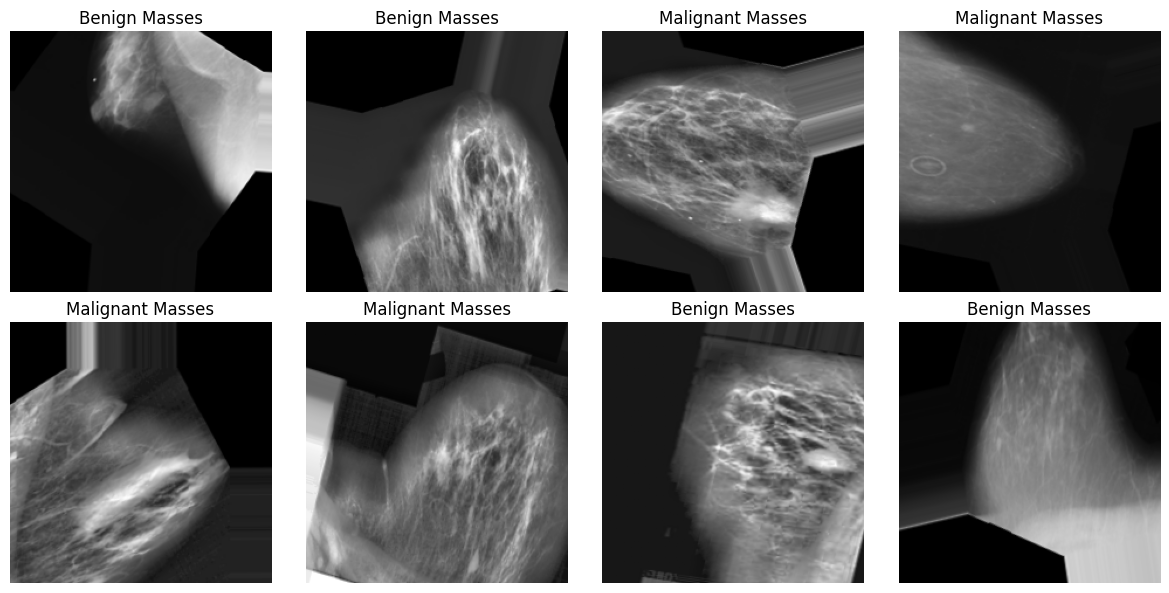

In [19]:
# Visualize sample images
images, labels = next(train_generator)
plt.figure(figsize=(12, 6))
for i in range(8):
    ax = plt.subplot(2, 4, i + 1)
    plt.imshow(images[i])
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis("off")
plt.tight_layout()
plt.show()


In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D,
                                     BatchNormalization, Dropout, Dense)
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import mixed_precision

# Enable mixed precision
mixed_precision.set_global_policy("mixed_float16")

def create_improved_model():
    model = Sequential([
        Input(shape=(224, 224, 3)),

        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(256, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        GlobalAveragePooling2D(),

        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(2, activation='softmax', dtype='float32')  # Keep float32 for softmax output
    ])
    return model

model = create_improved_model()
model.summary()

# Optimizer
LEARNING_RATE = 1e-4
optimizer = mixed_precision.LossScaleOptimizer(tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE))

# Compile model
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Model name
model_name = "Improved_Mammography_breast_cancer_model"

# Callbacks
checkpoint = ModelCheckpoint(
    filepath=f"{model_name}_best_model.keras",
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True,
    verbose=1
)

# Train the model
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    class_weight=class_weight_dict,
    callbacks=[checkpoint, reduce_lr, early_stop]
)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)                   │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 28, 28, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 456,642 (1.74 MB)

 Trainable params: 455,682 (1.74 MB)

 Non-trainable params: 960 (3.75 KB)

Epoch 1/40


2025-04-10 15:54:09.785688: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng19{k2=0} for conv (f16[64,3,3,32]{3,2,1,0}, u8[0]{0}) custom-call(f16[32,112,112,32]{3,2,1,0}, f16[32,112,112,64]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardFilter", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-04-10 15:54:09.944342: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.158834386s
Trying algorithm eng19{k2=0} for conv (f16[64,3,3,32]{3,2,1,0}, u8[0]{0}) custom-call(f16[32,112,112,32]{3,2,1,0}, f16[32,112,112,64]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardFilter", backend_config={"cudnn_conv_backend_con

280/538 ━━━━━━━━━━━━━━━━━━━━ 1:42 396ms/step - accuracy: 0.5615 - loss: 0.7278

2025-04-10 15:56:15.336861: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng19{k2=0} for conv (f16[64,3,3,32]{3,2,1,0}, u8[0]{0}) custom-call(f16[20,112,112,32]{3,2,1,0}, f16[20,112,112,64]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardFilter", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-04-10 15:56:15.782420: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.445732836s
Trying algorithm eng19{k2=0} for conv (f16[64,3,3,32]{3,2,1,0}, u8[0]{0}) custom-call(f16[20,112,112,32]{3,2,1,0}, f16[20,112,112,64]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardFilter", backend_config={"cudnn_conv_backend_con

537/538 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - accuracy: 0.5932 - loss: 0.6880
Epoch 1: val_loss improved from inf to 1.14056, saving model to Improved_Mammography_breast_cancer_model_best_model.keras
538/538 ━━━━━━━━━━━━━━━━━━━━ 339s 588ms/step - accuracy: 0.5934 - loss: 0.6877 - val_accuracy: 0.6271 - val_loss: 1.1406 - learning_rate: 1.0000e-04
Epoch 2/40
537/538 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.7598 - loss: 0.4844
Epoch 2: val_loss improved from 1.14056 to 0.84497, saving model to Improved_Mammography_breast_cancer_model_best_model.keras
538/538 ━━━━━━━━━━━━━━━━━━━━ 304s 560ms/step - accuracy: 0.7598 - loss: 0.4843 - val_accuracy: 0.6206 - val_loss: 0.8450 - learning_rate: 1.0000e-04
Epoch 3/40
537/538 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - accuracy: 0.7986 - loss: 0.4161
Epoch 3: val_loss did not improve from 0.84497
538/538 ━━━━━━━━━━━━━━━━━━━━ 308s 567ms/step - accuracy: 0.7986 - loss: 0.4161 - val_accuracy: 0.6443 - val_loss: 0.8832 - learning_rate: 1.0000e-04
Epoch

In [34]:
# Evaluate on test dataset
test_generator.reset()
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

768/768 ━━━━━━━━━━━━━━━━━━━━ 75s 98ms/step - accuracy: 0.5466 - loss: 1.0651
Test Accuracy: 75.20%
